# Determining optimal hyperparamter configuration for regional fire sizes 

Authors: Jatan Buch (v1, 220118)

## 1 - Loading packages and data products

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
data_dir= "../data/"
fire_file= data_dir + "burnarea_12km.nc"

In [3]:
fire_L3_freq_df= pd.read_hdf(data_dir + 'clim_L3_fire_freq_data.h5')
L3_weights, _= np.histogram(fire_L3_freq_df['fire_freq'], density= True, bins= [0, 1, 10, 20, 40, 70, 100]) 
sample_L3_weight_arr= pd.cut(fire_L3_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 10, 20, 40, 70, 100], \
                             labels= (L3_weights[0]/L3_weights)/np.sum(L3_weights[0]/L3_weights), include_lowest= True)
fire_L3_freq_df['sample_weight']= sample_L3_weight_arr

fire_L4_freq_df= pd.read_hdf(data_dir + 'clim_L4_fire_freq_data.h5')
L4_weights, _= np.histogram(fire_L4_freq_df['fire_freq'], density= True, bins= [0, 1, 3, 5, 20, 50]) 
sample_L4_weight_arr= pd.cut(fire_L4_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 3, 5, 20, 50], 
                            labels= (L4_weights[0]/L4_weights)/np.sum(L4_weights[0]/L4_weights), include_lowest= True)
fire_L4_freq_df['sample_weight']= sample_L4_weight_arr
#fire_freq_L3_data= np.array(fire_freq_df[fire_freq_df['month'] >= 372].fire_freq, dtype=np.float32)

## 2 - Testing

In [4]:
X_L3_freqs_train, X_L3_freqs_val, y_L3_freqs_train, y_L3_freqs_val, fire_L3_freq_test, X_L3_freqs_test, y_L3_freqs_test, \
        L3_freq_samp_weight_arr= fire_freq_data(fire_L3_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])
X_L4_freqs_train, X_L4_freqs_val, y_L4_freqs_train, y_L4_freqs_val, fire_L4_freq_test, X_L4_freqs_test, y_L4_freqs_test, \
        L4_freq_samp_weight_arr= fire_freq_data(fire_L4_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])

In [5]:
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test,\
        y_sizes_test= fire_size_data(res= '12km', dropcols= ['CAPE', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH'])

### 2.1 Loading saved fire frequency models

In [6]:
reg_freq_df= pd.read_hdf('../sav_files/ml_L3_fire_freqs.h5') 
#load_ml_freq(fire_L4_freq_df, fire_L3_freq_df, run_id= '22_01_17')

### 2.2 Setting up fire size models

In [7]:
nregions= 18
max_fire_train_arr= []
sum_fire_train_arr= []

for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= np.asarray(sum_fire_train_arr)

100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


In [9]:
%time mdn_size_model, _= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, \
                    size_test_df= fire_size_test, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                    func_flag= 'gpd', lnc_arr= [2, 8, 2], loco= True)

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 249 epochs
CPU times: user 4min 12s, sys: 29.2 s, total: 4min 41s
Wall time: 3min 17s


In [10]:
reg_ml_size_df= size_pred_func(mdn_model= mdn_size_model, stat_model= gpd_model, size_test_df= fire_size_test, X_test_dat= X_sizes_test,\
                                     max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, ncomps= 2, freq_flag= 'ml', \
                                     regmlfreq= reg_freq_df, debug= False, seed= 93)
reg_ml_size_groups= reg_ml_size_df.groupby('reg_indx')

100%|██████████| 18/18 [00:51<00:00,  2.86s/it]


### 2.4 Plotting

In [12]:
tot_months= 60
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[11, 12, 13], [14, 15, 16]]

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

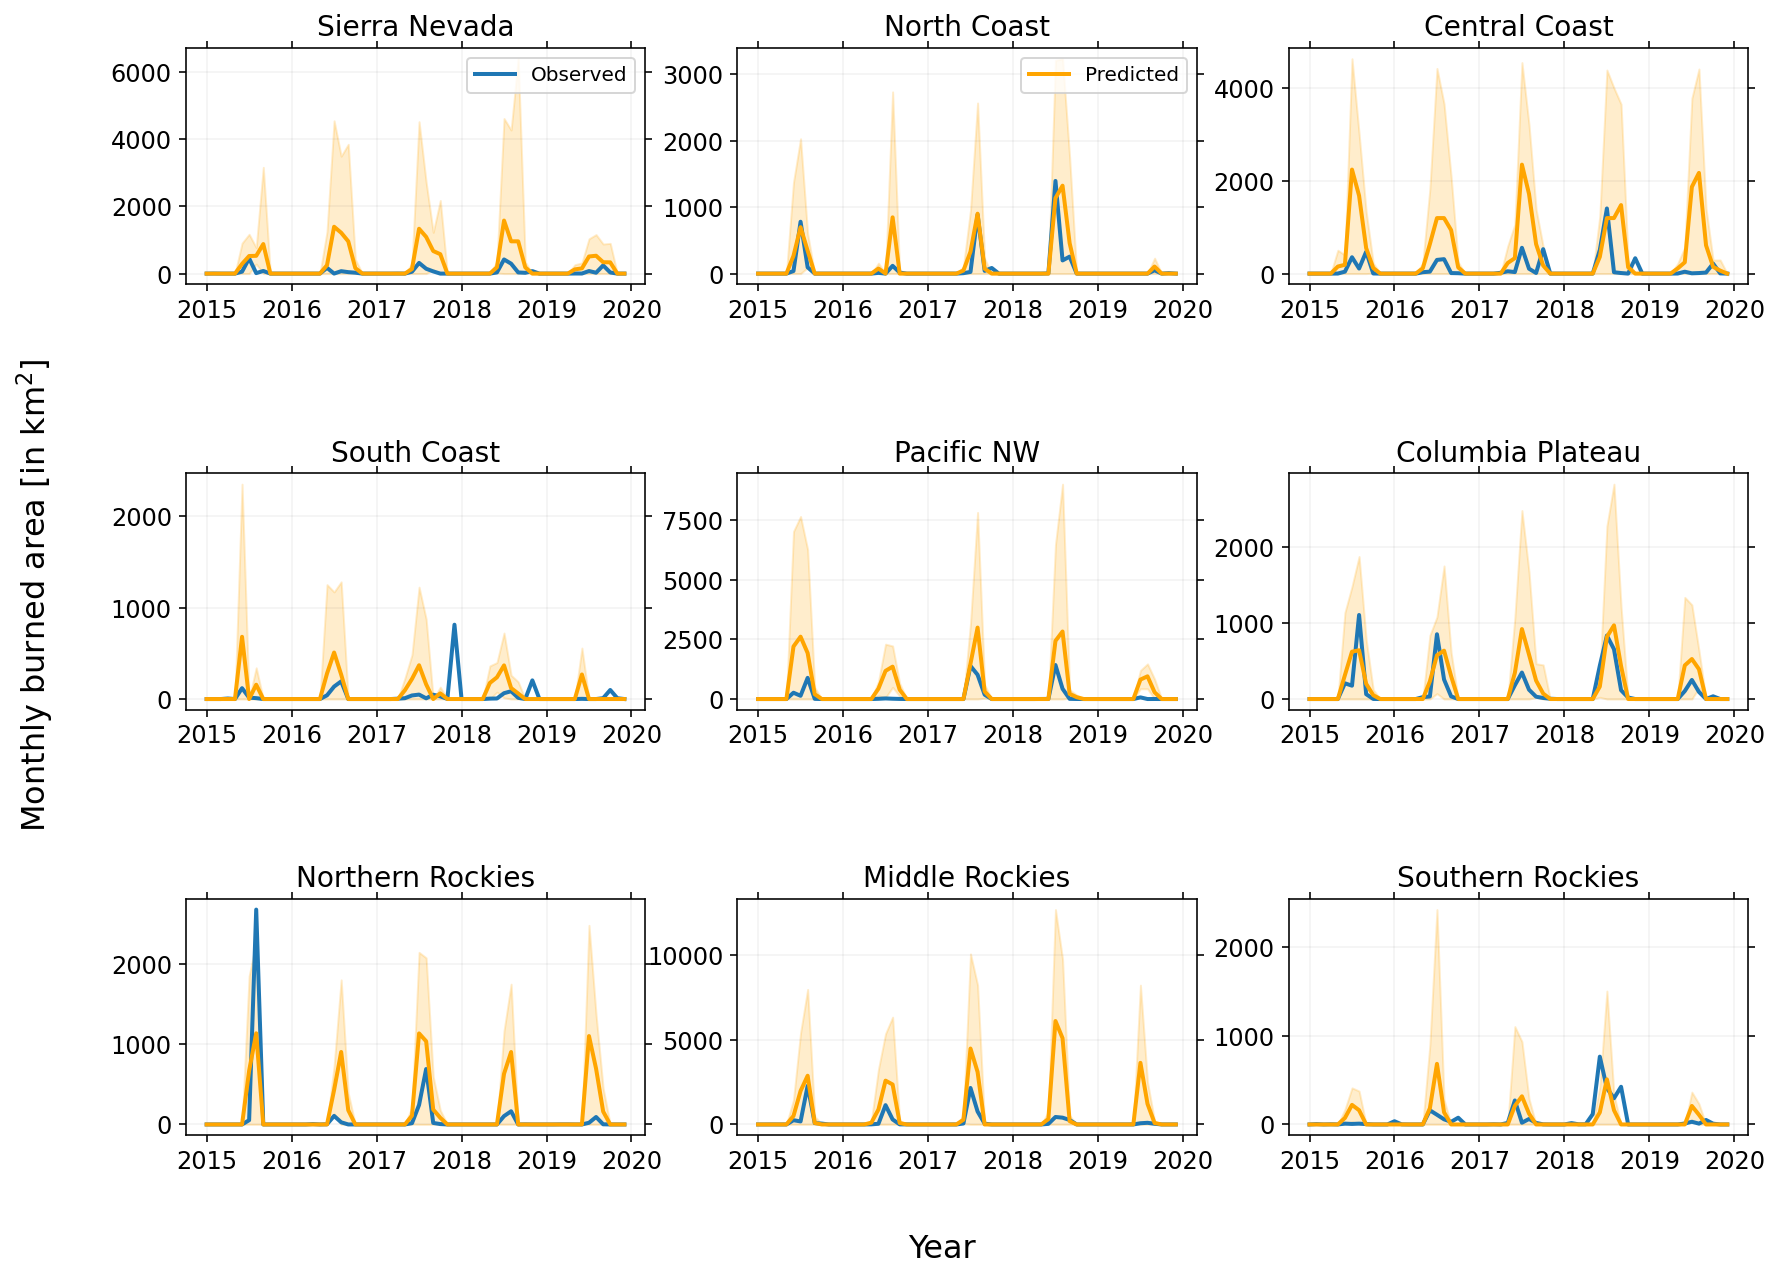

In [20]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)
obssizes_arr= []
predsizes_arr= []

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2);
        obssizes_arr.append(mon_burned_area(fire_file, regindx)[372:])
        predsizes_arr.append(reg_ml_size_groups.get_group(regindx)['mean_size'])
        
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_size_12km_unc_1.pdf', bbox_inches='tight');

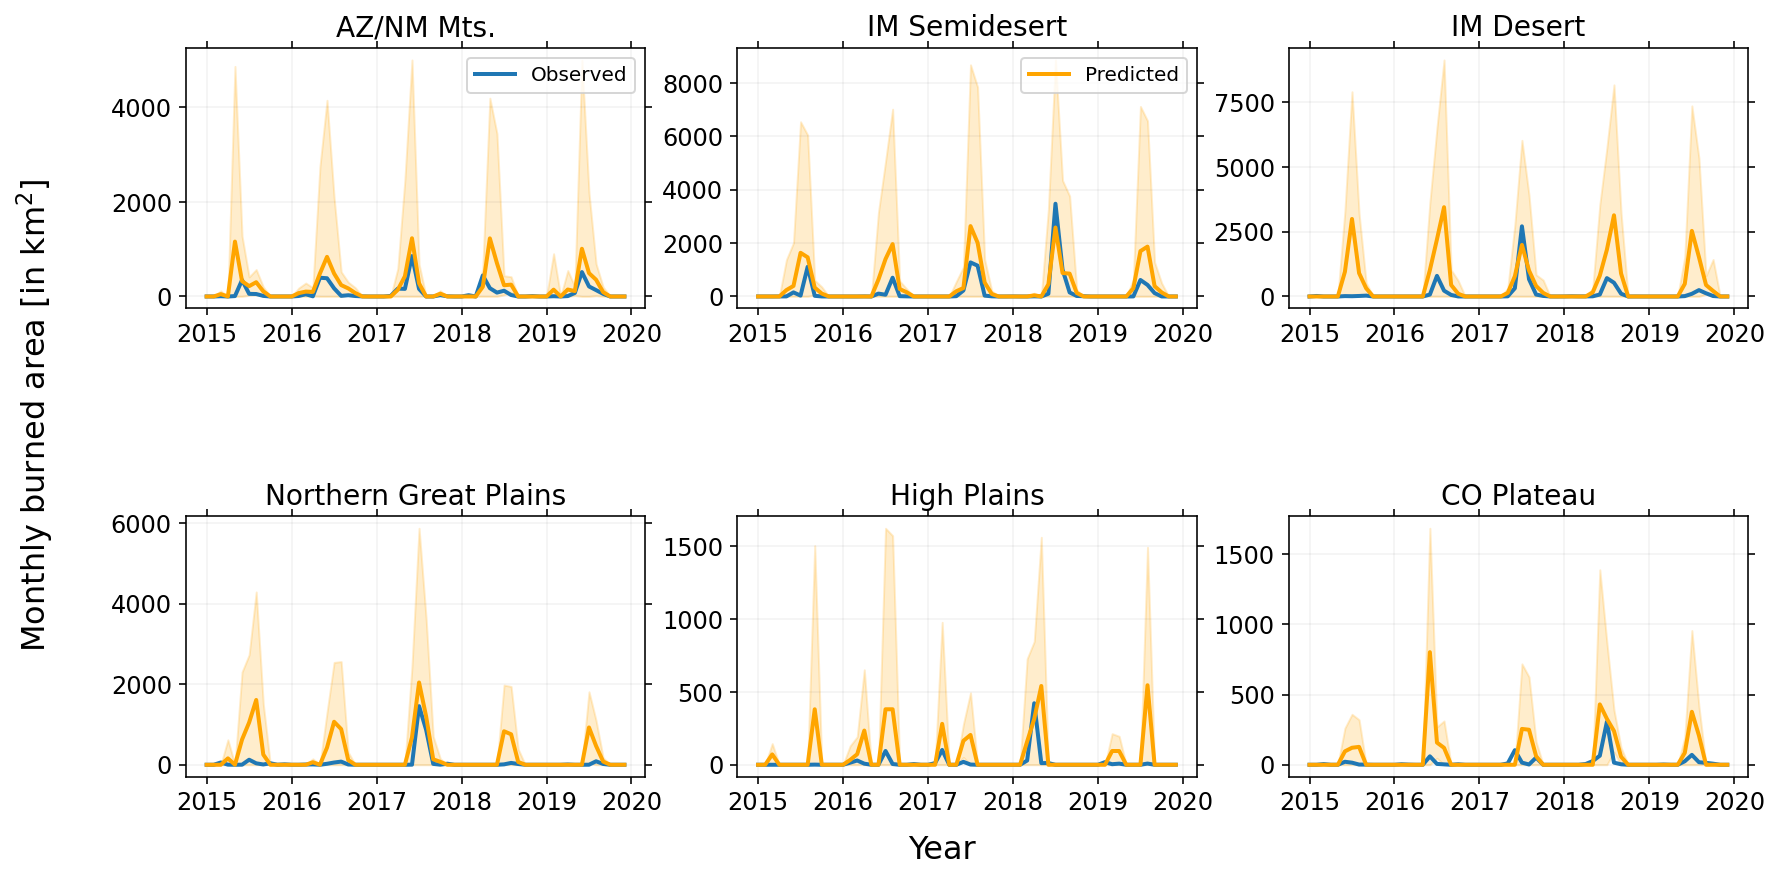

In [22]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2);
        obssizes_arr.append(mon_burned_area(fire_file, regindx)[372:])
        predsizes_arr.append(reg_ml_size_groups.get_group(regindx)['mean_size'])
        
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_size_12km_unc_2.pdf', bbox_inches='tight');

In [51]:
obssizes_arr= np.concatenate(obssizes_arr)
predsizes_arr= np.concatenate(predsizes_arr)
empcdf_obs= tfd.Empirical(obssizes_arr)
empcdf_pred= tfd.Empirical(predsizes_arr)

cdf_emp_obs= empcdf_obs.cdf(obssizes_arr)
cdf_emp_pred= empcdf_pred.cdf(predsizes_arr)
#pvec= mdn_size_model.predict(x= X_sizes_test)
#cdf_mod= gpd_model(pvec).cdf(y_sizes_test).numpy()

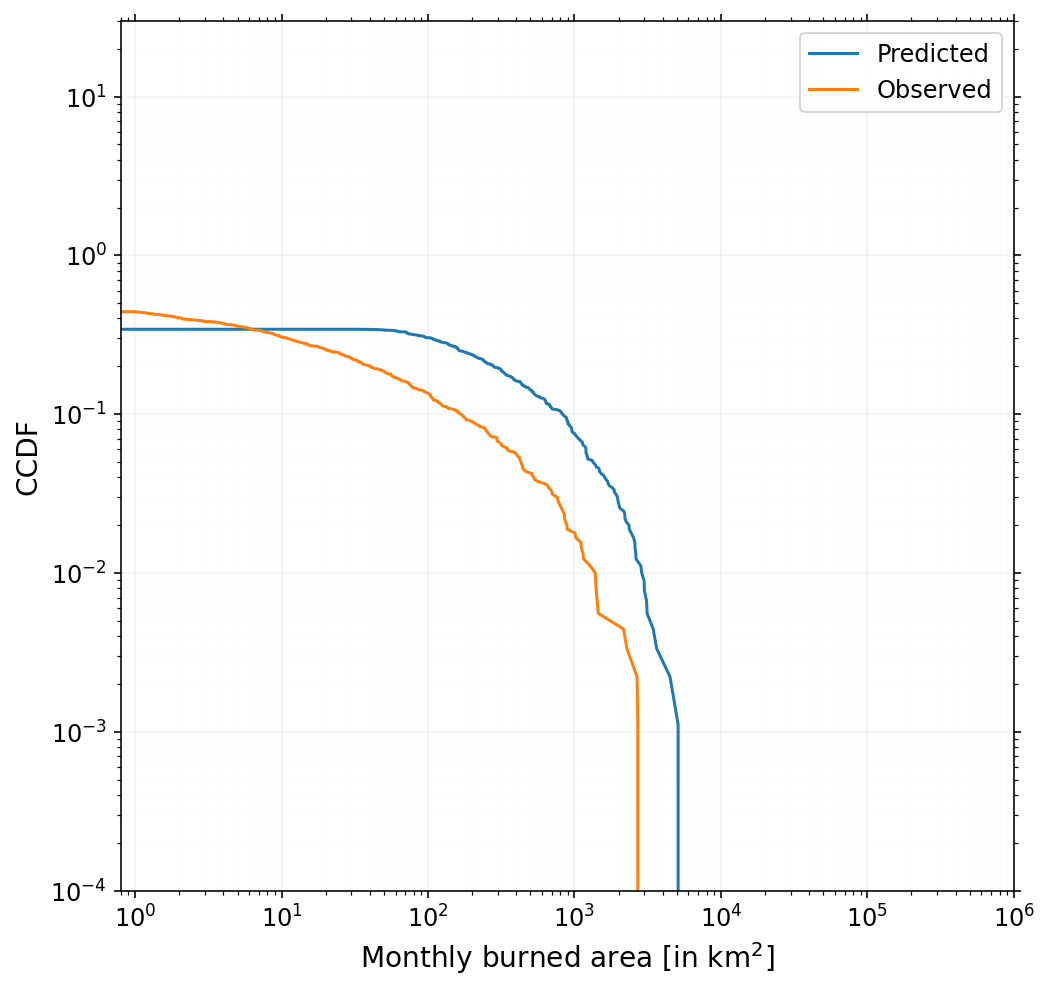

In [52]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.plot(np.sort(predsizes_arr), 1- np.sort(cdf_emp_pred), label= 'Predicted') 
plt.plot(np.sort(obssizes_arr), 1 - np.sort(cdf_emp_obs), label= 'Observed')
#plt.plot(np.sort(y_sizes_test), 1 - np.sort(cdf_mod), label= 'Model')

ax.set_xlabel(r'Monthly burned area [in ${\rm km}^2$]', fontsize= 14);
ax.set_ylabel(r'CCDF', fontsize= 14);

plt.ylim(10**-4, 30);
plt.xlim(0.8, 10**6);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/fire_size_ccdf.pdf', bbox_inches='tight');